<a href="https://colab.research.google.com/github/blondedman/blondedman/blob/main/siamese-network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Dataset

Market-1501 Dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
#!git clone https://github.com/parth1620/Person-Re-Id-Dataset

# Import Libraries

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import cv2
import timm
import torch

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Data and Configurations

In [ ]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[5]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

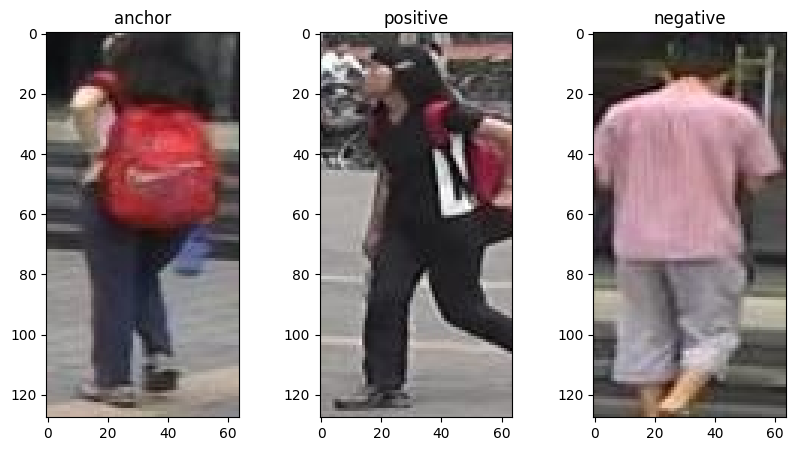

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("anchor")
ax1.imshow(A_img)

ax2.set_title("positive")
ax2.imshow(P_img)

ax3.set_title("negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [ ]:
class APN_dataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(A_img).permute(2, 0 ,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0 ,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0 ,1) / 255.0

        return A_img, P_img, N_img

In [ ]:
trainset = APN_dataset(train_df)
validset = APN_dataset(valid_df)

print(f"size of trainset : {len(trainset)}")
print(f"size of validset : {len(validset)}")

size of trainset : 3200
size of validset : 800


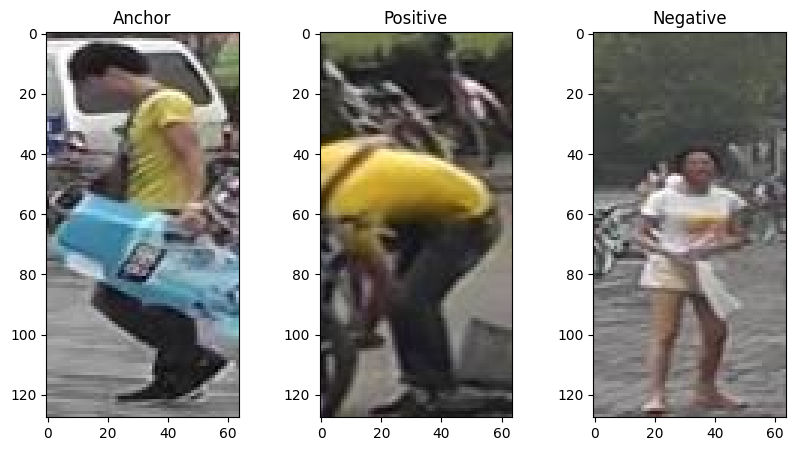

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset Into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"no. of batches in trainloader : {len(trainloader)}")
print(f"no. of batches in validloader : {len(validloader)}")

no. of batches in trainloader : 100
no. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
    break;

print(f"one image batch shape : {A.shape}")

one image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN(nn.Module):

    def __init__(self, emb_size = 512):
        super(APN, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)


    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [ ]:
model = APN()
model.to(DEVICE)

APN(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
    model.eval()  # OFF Dropout
    total_loss = 0.0

    with torch.no_grad():
        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()

        return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")

    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  8.34it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 0.6129346197843552 valid_loss: 0.4300525665283203


100%|██████████| 25/25 [00:02<00:00,  8.37it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 2 train_loss: 0.2683700667321682 valid_loss: 0.3076944971084595


100%|██████████| 25/25 [00:03<00:00,  8.08it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 3 train_loss: 0.17129128128290178 valid_loss: 0.26290296733379365


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 4 train_loss: 0.1082815869152546 valid_loss: 0.16449506044387818


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


EPOCHS: 5 train_loss: 0.06685792475938797 valid_loss: 0.2499118995666504


100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


EPOCHS: 6 train_loss: 0.05678528897464275 valid_loss: 0.2242563384771347


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 7 train_loss: 0.060007658153772354 valid_loss: 0.15211999744176866


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


EPOCHS: 8 train_loss: 0.045064726769924165 valid_loss: 0.15925028502941133


100%|██████████| 25/25 [00:03<00:00,  8.00it/s]


EPOCHS: 9 train_loss: 0.037976691648364064 valid_loss: 0.1841505217552185


100%|██████████| 25/25 [00:02<00:00,  8.38it/s]


EPOCHS: 10 train_loss: 0.042689885273575784 valid_loss: 0.1748243361711502


100%|██████████| 25/25 [00:02<00:00,  8.39it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 11 train_loss: 0.039364328160882 valid_loss: 0.13718450248241423


100%|██████████| 25/25 [00:02<00:00,  8.42it/s]


EPOCHS: 12 train_loss: 0.06404943749308586 valid_loss: 0.23224700212478638


100%|██████████| 25/25 [00:02<00:00,  8.40it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 13 train_loss: 0.0839260060340166 valid_loss: 0.12142067193984986


100%|██████████| 25/25 [00:03<00:00,  8.25it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 14 train_loss: 0.026289762407541276 valid_loss: 0.11931746900081634


100%|██████████| 25/25 [00:03<00:00,  8.25it/s]

EPOCHS: 15 train_loss: 0.02352061599493027 valid_loss: 0.12038274168968201


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A. to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # c,h,w --> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)

    return df_enc

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

<ipython-input-40-efb713b231f1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
100%|██████████| 4000/4000 [00:42<00:00, 

In [ ]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.076168,0.837317,0.228130,-0.406914,0.471525,0.509880,-0.266439,-0.291295,0.156749,...,0.946199,-0.715328,-0.249918,0.707034,-0.829228,0.218005,-0.299043,0.393075,-0.095870,-0.049791
1,1420_c3s3_061978_03.jpg,0.041226,0.948979,-0.183048,-0.277974,0.246919,0.745974,-0.260064,-0.470685,-0.010377,...,1.221834,-0.485877,-0.244348,0.741286,-0.752215,0.199116,-0.254269,0.652756,-0.194940,-0.410855
2,1420_c5s3_062565_05.jpg,-0.091351,0.954416,-0.071229,-0.388575,0.273477,0.761101,-0.220941,-0.394907,0.029253,...,1.053887,-0.536974,-0.325514,0.719816,-0.731159,0.198386,-0.124684,0.667889,-0.039274,-0.246560
3,1420_c6s3_085592_04.jpg,-0.205418,0.643706,-0.071252,-0.393765,0.124875,0.416157,-0.261073,-0.391473,0.038699,...,0.721922,-0.905724,-0.123452,0.948055,-0.674666,0.050440,-0.160446,0.358345,-0.092179,-0.181538
4,0663_c5s3_085987_03.jpg,-0.539750,-0.251795,-0.478366,-0.232839,-0.224872,-0.187215,0.235576,-0.101062,0.148898,...,-0.288180,-0.212104,-0.424128,-0.059642,0.461638,-0.287908,0.510698,0.247040,0.856169,0.516051


# Final Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [ ]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

In [ ]:
def plot_closest_imgs(anc_img_names, data_dir, img, img_path, closest_idx, distance, no_of_closest=5):

    plt.figure(figsize=(15, 5))
    plt.subplot(1, no_of_closest + 1, 1)
    plt.imshow(cv2.imread(img_path))
    plt.title("Anchor")
    plt.axis("off")

    for i in range(no_of_closest):
        closest_img_path = f"{data_dir}/{anc_img_names[closest_idx[i]]}"
        closest_img = cv2.imread(closest_img_path)
        plt.subplot(1, no_of_closest + 1, i + 2)
        plt.imshow(closest_img)
        plt.title(f"Dist: {distance[i]:.2f}")
        plt.axis("off")

    plt.show()


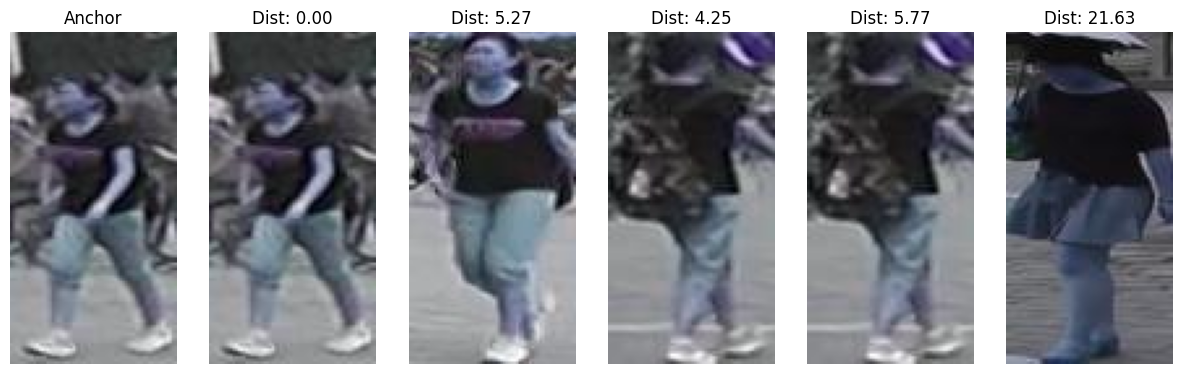

In [ ]:
plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);